In [8]:
import pandas as pd
import io
from math import sqrt
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
from scipy import stats
from scipy import fft, ifft
import math
# scikit-learn bootstrap
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from decimal import Decimal
import timeit

## Setting defaults for plots
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
#plt.rcParams['xtick.labelrotation'] = 45
plt.axes.labelrotation: 45

# Data cleaning

In [9]:
#Loading the data
dataset = 'price'  
#dataset = 'Block_size'
#dataset = 'Block_time'
df_orig = pd.read_csv('data/'+dataset+'.csv', sep=',') 
df_orig

,Date,Bitcoin,Ethereum,Litecoin,Bitcoin Cash,Ethereum Classic,XRP,Bitcoin SV,Dash,Zcash,Monero,Dogecoin,Bitcoin Gold,Peercoin,Vertcoin,Reddcoin,Feathercoin,Blackcoin,Novacoin
0,2010-07-17,0.0495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-18,0.0726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-19,0.0859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-20,0.0783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-21,0.0767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,2020-09-17,10899.0000,381.801,48.532,233.495,5.313,0.253,163.859,72.914,58.734,90.701,0.00281,8.272,0.228,0.249,0.001010,0.00771,0.0409,0.180
3716,2020-09-18,10931.0000,384.584,48.465,234.223,5.346,0.249,162.912,72.517,58.696,92.658,0.00280,8.290,0.228,0.252,0.000977,0.00782,0.0407,0.181
3717,2020-09-19,11019.0000,383.368,48.442,233.978,5.380,0.252,162.016,72.543,58.227,93.179,0.00280,8.272,0.226,0.253,0.000933,0.00791,0.0414,0.182
3718,2020-09-20,10928.0000,376.519,47.579,228.069,5.299,0.246,156.213,71.266,57.231,92.763,0.00279,8.157,0.225,0.249,0.000925,0.00779,0.0400,0.181


In [10]:
# dealing with nulls

df_orig.isnull().sum()
df_orig = df_orig.dropna(axis=1,how='all')
# dropping nulls is not an option because we have time series. 
# Cutting time series is not an option because we want to have different starting points
# Since we do not have many missing values after each coin is introduced, we use forward fill
# If at any point we notice that the data is missing for a long time period, we will retrieve data from another channel
df = df_orig.fillna(method='ffill')


In [11]:
# changing the column names
#To remove white space at the both ends of string:
df.columns = df_orig.columns.str.strip()

#To replace white space everywhere
df.columns = df.columns.str.replace(' ', '_')


df["Date"] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')
# saving the clean data
df.to_csv('data/price_cleandata.csv', index=False)

In [12]:
# enable if you want to take only the last year of observations
# df = df.iloc[-366:,:]

# Functions

In [13]:
def firstNonNan(timeseries):
    for item in timeseries:
        if math.isnan(item) == False:
            return item

def normalize(timeseries):
    normalseries = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())
    return normalseries 

def standardize(timeseries):
    standardseries = (timeseries-timeseries.mean())/(timeseries.std())
    return standardseries 

# Analysis

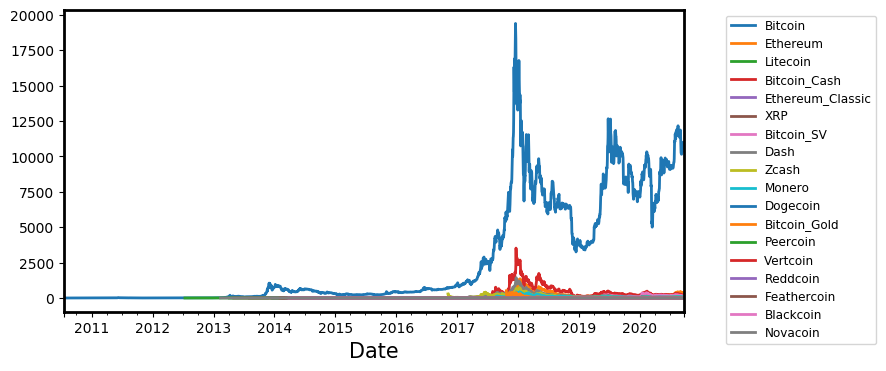

In [14]:
# we see that the scale of prices of different coins vary a lot. Maybe we can use returns instead 

# (or should we normalize / standardize the prices???)
ax =df.plot(legend=False, figsize = (8,4))
ax.legend(loc='upper right', bbox_to_anchor=(1.32, 1), fontsize = 'xx-small')
plt.savefig(dataset+'.png', transparent = True, dpi=500, bbox_inches='tight')

### Formula for return rate

$ \text{Rate of return} = \frac{\text{current value - original value}}{\text{original value}}*100$

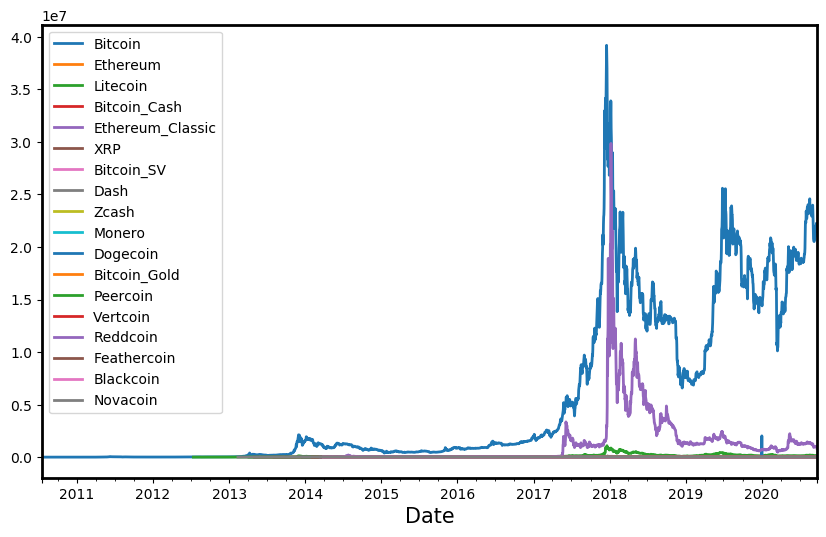

In [15]:
df_returns= (df-df.apply(firstNonNan))/ df.apply(firstNonNan) *100
df_returns.plot()

# we see that ethereum, bitcoin and litecoin dominate the market return wise

### Formula for normalizing

$ \text{Normalized series} = \frac{\text{current value - min values}}{\text{max value - min value}}*100$

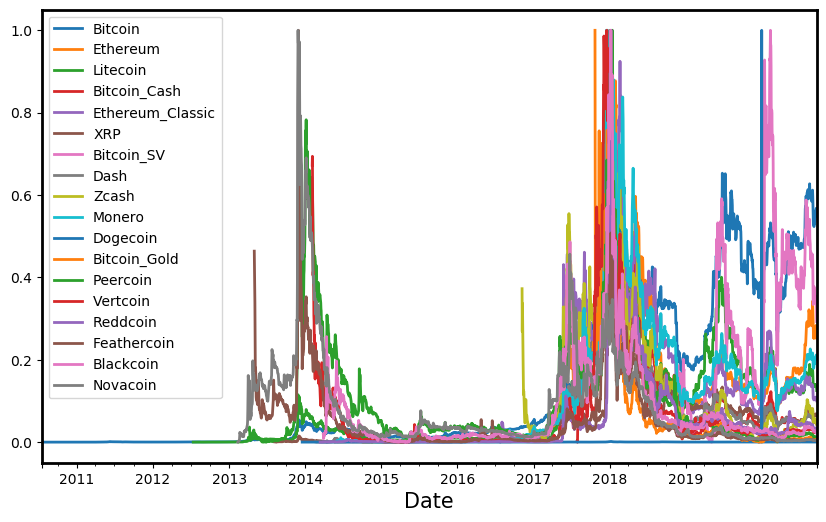

In [16]:
# we try normalizing here
df_normal = df.apply(normalize)
df_normal.plot()

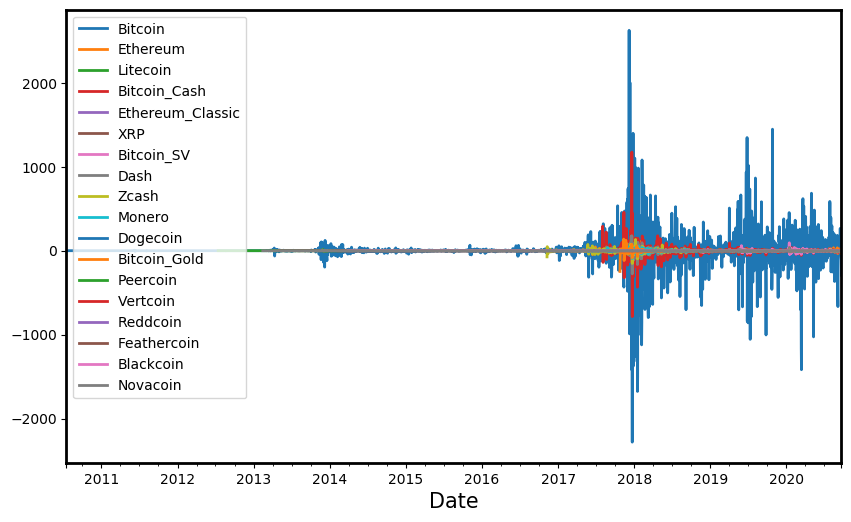

In [17]:
# detrending time series 
df_detrend = df.diff()

#df_detrend = df_detrend.apply(normalize)
df_detrend.plot()

### Formula for Standardizing 

$ \text{Standardized series} = \frac{\text{current value -  mean}}{\text{standard deviation}}$	


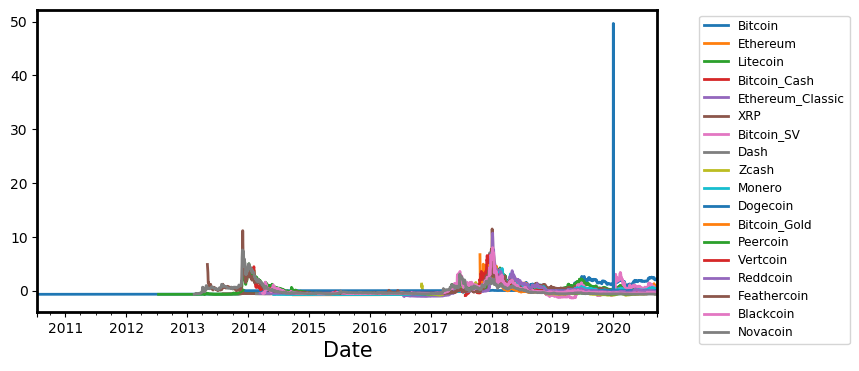

In [18]:
df_std= df.apply(standardize)
ax =df_std.plot(legend=False, figsize = (8,4))
ax.legend(loc='upper right', bbox_to_anchor=(1.32, 1), fontsize = 'xx-small')
plt.savefig(dataset+'.png', transparent = True, dpi=500, bbox_inches='tight')

In [19]:
# choose the dataframe you want to use for fft and rename it here
df_usecase = df_std

# FFT

The FFT $y[k]$ of length $N$ of the a sequence $x[n]$ length $N$ is defined as
$$
y[k]=\sum_{n=0}^{N-1} e^{-2 \pi j \frac{k n}{N}} x[n]
$$


### comments

You may have too little data for FFT/DWT to make sense. DTW may be better, but I also don't think it makes sense for sales data - why would there be a x-week temporal offset from one location to another? It's not as if the data were captured at unknown starting weeks.

FFT and DWT are good when your data will have interesting repetitive patterns, and you have A) a good temporal resolution (for audio data, e.g. 16000 Hz - I am talking about thousands of data points!) and B) you have no idea of what frequencies to expect. If you know e.g. you will have weekly patterns (e.g. no sales on sundays) then you should filter them with other algorithms instead.

DTW (dynamic time-warping) is good when you don't know when the event starts and how they align. Say you are capturing heart measurements. You cannot expect to have the hearts of two subjects to beat in synchronization. DTW will try to align this data, and may (or may not) succeed in matching e.g. an anomaly in the heart beat of two subjects. In theory...

#### Step 1

Perform a fast Fourier transform on the time series data. This decomposes your time series data into mean and frequency components and allows you to use variables for clustering that do not show heavy autocorrelation like many raw time series.

#### Step 2

If time series is real-valued, discard the second half of the fast Fourier transform elements because they are redundant.

#### Step 3

Separate the real and imaginary parts of each fast Fourier transform element.

#### Step 4

Perform model-based clustering on the real and imaginary parts of each frequency element.

#### Step 5

Plot the percentiles of the time series by cluster to examine their shape.

Alternately, you could omit the DC components of the fast Fourier transform to avoid your clusters being based on the mean and instead on the series defined by the Fourier transform, which represents the shape of the time series.

You will also want to calculate the amplitudes and phase angles from the fast Fourier transform so that you can explore the distribution of time series spectra within clusters. See this StackOverflow answer on how to do that for real-valued data.

You could also plot the percentiles of time series shape by cluster by computing the Fourier series from the amplitudes and phase angles (the resulting time series estimate will not perfectly match the original time series). You could also plot the percentiles of the raw time series data by cluster. Here is an example of such a plot, which came about from a harmonic analysis of NDVI data I just did today:

1st, 25th, 50th, 75th, and 99th percentiles of period-level NDVI measures by clusters derived from model-based clustering using Mclust package in R

Finally, if your time series is not stationary (i.e., mean and variance shift over time), it may be more appropriate to use a wavelet transform rather than a Fourier transform. You would do so at the cost of information about frequencies while gaining information about location.

In [20]:
df_usecase.isnull().sum()

Bitcoin                0
Ethereum            1536
Litecoin             727
Bitcoin_Cash        2567
Ethereum_Classic    2199
XRP                 1114
Bitcoin_SV          3054
Dash                1314
Zcash               2305
Monero              1418
Dogecoin            1250
Bitcoin_Gold        2655
Peercoin             994
Vertcoin            1298
Reddcoin            1336
Feathercoin         1020
Blackcoin           1351
Novacoin             941
dtype: int64

## FFT 

In [21]:
# FFT with normalizing
num_coins = df_usecase.shape[1] 
dt = .005; # defines how many frequencies should be taken
t = np.arange(0,1,dt);
n_sample = len(t)
cols = list(df_usecase.columns)
df_fft_fixed = pd.DataFrame() 
pd.DataFrame(df_fft_fixed, columns = cols) 

for col in df.columns:
    col_values =  df_usecase[col][df_usecase[col].notna()]
    fft_values = fft(col_values, n_sample)
    fft_values = fft_values[~np.isnan(fft_values)]
    df_fft_fixed[col] = fft_values 

df_fft_fixed

,Bitcoin,Ethereum,Litecoin,Bitcoin_Cash,Ethereum_Classic,XRP,Bitcoin_SV,Dash,Zcash,Monero,Dogecoin,Bitcoin_Gold,Peercoin,Vertcoin,Reddcoin,Feathercoin,Blackcoin,Novacoin
0,-139.982436+0.000000j,-160.136067+0.000000j,-141.136783+0.000000j,212.180246+0.000000j,-207.503127+0.000000j,-116.825879+0.000000j,-184.185346+0.000000j,-116.395179+0.000000j,-110.586832+0.000000j,-148.254601+0.000000j,-5.071769+0.000000j,330.879394+0.000000j,-130.588778+0.000000j,53.308780+0.000000j,-100.725867+0.000000j,99.645920+0.000000j,0.889152+0.000000j,47.882646+0.000000j
1,0.000883+0.003439j,-0.004802+0.033407j,-0.011001+0.035027j,26.857431+188.989519j,4.815618-2.558097j,-0.846732+3.637775j,44.261230-4.377250j,-1.852612+1.713646j,31.627483+8.211439j,-0.118817-1.326169j,-0.078977-0.203706j,-31.649765-163.333629j,7.350892-0.306965j,22.084938-41.528461j,-0.442002+1.699834j,11.076780+5.208054j,-19.551471-38.247889j,-21.720276+39.818753j
2,0.000720+0.000649j,0.068891+0.007470j,0.011442+0.000857j,-82.513825+26.096508j,0.628177-0.610321j,-1.142635-0.759984j,30.632685+3.209411j,0.706591-0.443678j,14.379882+4.092911j,-0.003068-0.513043j,-0.124844+0.031360j,-24.583394-13.364203j,2.008904-0.759943j,26.448732-34.618338j,-0.681538-0.277635j,29.185028-24.433693j,-0.579389-2.873622j,3.825333+40.543073j
3,0.000349+0.001685j,-0.000646+0.044512j,-0.017983-0.005070j,-38.425903+10.106874j,-0.457770-1.845243j,0.955295+1.463393j,20.058382+23.482158j,-0.614261+0.253489j,16.579082-0.787758j,-0.176988-0.334127j,0.014649+0.059655j,8.157164+0.881351j,-0.451812+1.134722j,19.516301-18.618567j,0.472666+0.148848j,15.561931-8.029579j,-7.057043-7.174678j,-7.978188+21.412913j
4,-0.000097+0.000639j,0.032250-0.032297j,0.006138+0.000416j,-1.168832-10.134284j,-0.173333-2.033280j,-0.976077-0.023999j,7.649449+27.395856j,0.335893-0.078568j,9.965220+0.763121j,-0.031938-0.290962j,0.037617+0.024041j,-1.934132+13.836190j,-0.389697+1.869136j,19.010582-21.775742j,-0.252371+0.495206j,25.525841-7.049252j,-17.630570-5.673014j,-4.862094+2.081402j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000270-0.000718j,0.038143+0.000667j,-0.006836-0.001036j,8.033105-29.491205j,-0.390665+0.898024j,0.733318+0.161803j,1.130382-17.407103j,-0.197910+0.103399j,7.319594+1.763102j,-0.327005+0.346183j,0.042853+0.026818j,13.871212+7.119549j,-0.731654-1.537338j,13.455514+18.373852j,-0.329346+0.214545j,14.933097+13.008921j,-13.555163-8.906104j,0.443640-2.479037j
196,-0.000097-0.000639j,0.032250+0.032297j,0.006138-0.000416j,-1.168832+10.134284j,-0.173333+2.033280j,-0.976077+0.023999j,7.649449-27.395856j,0.335893+0.078568j,9.965220-0.763121j,-0.031938+0.290962j,0.037617-0.024041j,-1.934132-13.836190j,-0.389697-1.869136j,19.010582+21.775742j,-0.252371-0.495206j,25.525841+7.049252j,-17.630570+5.673014j,-4.862094-2.081402j
197,0.000349-0.001685j,-0.000646-0.044512j,-0.017983+0.005070j,-38.425903-10.106874j,-0.457770+1.845243j,0.955295-1.463393j,20.058382-23.482158j,-0.614261-0.253489j,16.579082+0.787758j,-0.176988+0.334127j,0.014649-0.059655j,8.157164-0.881351j,-0.451812-1.134722j,19.516301+18.618567j,0.472666-0.148848j,15.561931+8.029579j,-7.057043+7.174678j,-7.978188-21.412913j
198,0.000720-0.000649j,0.068891-0.007470j,0.011442-0.000857j,-82.513825-26.096508j,0.628177+0.610321j,-1.142635+0.759984j,30.632685-3.209411j,0.706591+0.443678j,14.379882-4.092911j,-0.003068+0.513043j,-0.124844-0.031360j,-24.583394+13.364203j,2.008904+0.759943j,26.448732+34.618338j,-0.681538+0.277635j,29.185028+24.433693j,-0.579389+2.873622j,3.825333-40.543073j


In [22]:
# Calculation of x-axis
freq = 1/(dt*n_sample) * np.arange(0,n_sample); # Create x-axis of frequencies in Hz
#L = np.arange(1,(n_sample//2)); # Only plot the first half of freqs

In [23]:
PSD = df_fft_fixed*(df_fft_fixed.apply(np.conj))/n_sample; # Power spectrum (power per freq) # same as amplitude
indices = abs(PSD)>0.0001; # Find all freqs with large power
PSDclean = PSD*indices; # Zero out all others
fhat = indices*df_fft_fixed; # Zero out small Fourier coeffs. in Y
ffilt = ifft(fhat); # Inverse FFT for filtered time signal

In [24]:
# Plotting each timeseries with its absolute frequency(sorted)


# plotting amplitudes:  amplitudes = 2 / n_samples * np.abs(y_fft). I do 1/n because n is already divided by 2
# ref: https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html

cols = list(df_usecase.columns)
fig, ax = plt.subplots(num_coins,2, figsize=(60,180))
for i in range(0, num_coins):
    ax[i,0].plot(df_usecase[cols[i]])
    ax[i,0].set_title(cols[i])
    ax[i,1].plot(freq[:n_sample//2],abs(PSD[cols[i]].iloc[:n_sample//2]),'r')
    ax[i,1].set_title('Amplitude')
    #ax[i,2].bar(freq[:n_sample//2],abs(PSDclean[cols[i]].iloc[:n_sample//2]))
    #ax[i,2].set_title('Filtered signal')
for ax in fig.axes:
    ax.tick_params(labelrotation=45)

In [26]:
# calculating the characteristics
import tsfresh
import tsfresh.feature_extraction.feature_calculators as tsfresh_calc
#!pip install hurst
from hurst import compute_Hc
#!pip install nolds
import nolds # https://nolds.readthedocs.io/en/latest/

df= df_usecase
# definitions given in 
# https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#module-tsfresh.feature_extraction.feature_calculators
#https://tsfresh.readthedocs.io/en/latest/text/_generated/tsfresh.feature_extraction.feature_calculators.html

# uncomment this if you want clustering without spectrum 
PSD = pd.DataFrame() 
PSD = pd.DataFrame(PSD, columns = cols) 

PSD.loc['mean'] = df.apply(lambda a: tsfresh_calc.mean(a.dropna()))
PSD.loc['standard_deviation'] = df.apply(lambda a: tsfresh_calc.standard_deviation(a.dropna()))
PSD.loc['skewness'] = df.apply(lambda a: tsfresh_calc.skewness(a.dropna()))
PSD.loc['kurtosis'] = df.apply(lambda a: tsfresh_calc.kurtosis(a.dropna()))
PSD.loc['maximum'] = df.apply(lambda a: tsfresh_calc.maximum(a.dropna()))
PSD.loc['minimum'] = df.apply(lambda a: tsfresh_calc.minimum(a.dropna()))
PSD.loc['lowerquant'] = df.apply(lambda a: tsfresh_calc.quantile(a.dropna(),0.25))
PSD.loc['median'] = df.apply(lambda a: tsfresh_calc.median(a.dropna()))
PSD.loc['upperquant'] = df.apply(lambda a: tsfresh_calc.quantile(a.dropna(),0.75))
PSD.loc['VaR99'] = df.apply(lambda a: tsfresh_calc.quantile(a.dropna(),0.01))
PSD.loc['VaR95'] = df.apply(lambda a: tsfresh_calc.quantile(a.dropna(),0.05))
PSD.loc['slope'] = [i[0][1] for i in df.apply(lambda a: tsfresh_calc.linear_trend(a.dropna(),[{"attr": "slope"}]))]
#PSD.loc['intercept'] = [i[0][1] for i in df.apply(lambda a: tsfresh_calc.linear_trend(a.dropna(),[{"attr": "intercept"}]))]
PSD.loc['intercept'] = df.apply(firstNonNan)
#PSD.loc['abs_energy'] = df.apply(lambda a: tsfresh_calc.abs_energy(a.dropna()))
PSD.loc['autocorrelation'] = df.apply(lambda a: tsfresh_calc.autocorrelation(a.dropna(),1))
#PSD.loc['partial_autocorrelation'] = [i[0][1] for i in df.apply(lambda a: tsfresh_calc.partial_autocorrelation(a.dropna(),[{"lag": 1}]))]
#PSD.loc['sample_entropy'] = df.apply(lambda a: tsfresh_calc.sample_entropy(a.dropna()))
#PSD.loc['self_similarity'] = [i[0] for i in df.apply(lambda a: compute_Hc(a.dropna()))]
PSD.loc['self_similarity'] = df.apply(lambda a: nolds.dfa(a.dropna()))
PSD.loc['chaos'] = df.apply(lambda a: nolds.lyap_r(a.dropna(),min_tsep=10, lag=1))

#PSD.to_csv('data/price_characteristics.csv', index=False)
#PSD.to_csv('data/blocktime_characteristics.csv', index=False)
#PSD.to_csv('data/blocksize_characteristics.csv', index=False)


PSD

,Bitcoin,Ethereum,Litecoin,Bitcoin_Cash,Ethereum_Classic,XRP,Bitcoin_SV,Dash,Zcash,Monero,Dogecoin,Bitcoin_Gold,Peercoin,Vertcoin,Reddcoin,Feathercoin,Blackcoin,Novacoin
mean,-4.393141e-17,-9.058180e-16,1.103546e-16,-1.292211e-16,1.365187e-15,1.747771e-17,-8.884063e-16,-9.449124e-16,-2.055678e-17,7.363306e-16,-1.061552e-17,8.202098e-16,-1.380244e-15,2.245887e-16,6.336631e-16,-1.751891e-15,-7.682753e-16,2.234269e-15
standard_deviation,9.998656e-01,9.997710e-01,9.998329e-01,9.995663e-01,9.996712e-01,9.998081e-01,9.992490e-01,9.997922e-01,9.996466e-01,9.997828e-01,9.997976e-01,9.995304e-01,9.998166e-01,9.997935e-01,9.997902e-01,9.998148e-01,9.997889e-01,9.998201e-01
skewness,1.338279e+00,1.949681e+00,2.389012e+00,2.321754e+00,1.491178e+00,4.193442e+00,6.779994e-01,3.126423e+00,1.756298e+00,2.145029e+00,4.969172e+01,2.879476e+00,2.510852e+00,3.636828e+00,4.174605e+00,3.379234e+00,3.396685e+00,3.101600e+00
kurtosis,6.717652e-01,4.653531e+00,7.272215e+00,6.156605e+00,2.238930e+00,2.947087e+01,7.864275e-02,1.177712e+01,3.208423e+00,5.299512e+00,2.469511e+03,8.350996e+00,7.017188e+00,1.479209e+01,2.452649e+01,1.717228e+01,1.525099e+01,1.291590e+01
maximum,4.406943e+00,5.289966e+00,6.544395e+00,5.865522e+00,4.391534e+00,1.145271e+01,3.370238e+00,7.034117e+00,4.714169e+00,5.051272e+00,4.967652e+01,6.672880e+00,6.555264e+00,6.604819e+00,1.067503e+01,1.113591e+01,7.985605e+00,7.557254e+00
minimum,-6.999457e-01,-8.025306e-01,-7.062648e-01,-9.403938e-01,-1.110470e+00,-6.250058e-01,-1.387290e+00,-6.033048e-01,-8.882843e-01,-7.588039e-01,-2.834031e-02,-5.404107e-01,-7.220697e-01,-5.029854e-01,-5.229183e-01,-5.872639e-01,-6.453908e-01,-7.047477e-01
lowerquant,-6.946435e-01,-7.684906e-01,-6.421209e-01,-5.973318e-01,-6.408363e-01,-6.121782e-01,-8.689972e-01,-5.850371e-01,-6.789656e-01,-7.473400e-01,-2.765743e-02,-4.748779e-01,-5.758444e-01,-4.748262e-01,-5.117784e-01,-5.271295e-01,-5.144747e-01,-5.612440e-01
median,-5.799548e-01,-1.906018e-01,-5.297950e-01,-4.182379e-01,-3.589541e-01,-5.541183e-01,-1.523845e-01,-2.521976e-01,-5.039434e-01,-1.785742e-01,-2.326010e-02,-3.874583e-01,-4.518357e-01,-3.284987e-01,-2.870904e-01,-4.204301e-01,-3.961771e-01,-4.294480e-01
upperquant,6.498786e-01,3.235855e-01,3.850498e-01,1.633549e-01,5.660080e-01,3.293260e-01,6.933280e-01,1.028414e-01,5.108315e-01,3.604770e-01,-1.524145e-02,-1.910586e-01,2.191041e-01,-3.334301e-02,-1.388707e-03,9.354295e-02,-6.257774e-02,3.732029e-01
VaR99,-6.999424e-01,-8.017344e-01,-7.061129e-01,-8.446060e-01,-1.094837e+00,-6.211965e-01,-1.376905e+00,-6.022674e-01,-8.578409e-01,-7.582874e-01,-2.824719e-02,-5.366607e-01,-7.099516e-01,-5.012102e-01,-5.198282e-01,-5.828719e-01,-6.377566e-01,-6.786561e-01


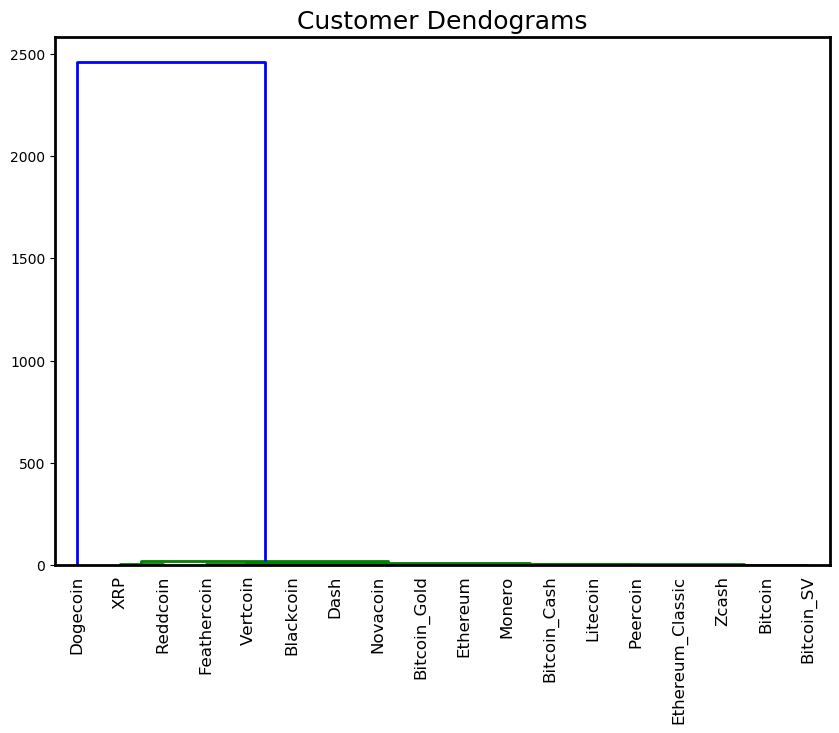

In [27]:
import scipy.cluster.hierarchy as shc

df_fft_fixed_T = abs(PSD.T) # using the power for clustering
#df_fft_fixed_T = abs(PSDclean.T) # using the cleaned power for clustering
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(df_fft_fixed_T, method='centroid'), leaf_rotation=90,labels=df_fft_fixed_T.index)


In [28]:
## Heirarchical Clustering
from sklearn.cluster import AgglomerativeClustering
n_clusters=4
cluster = AgglomerativeClustering(n_clusters, affinity='euclidean', linkage='ward')
cluster_labels_heirarchy= cluster.fit_predict(abs(df_fft_fixed_T))

#printing clusters
for i in range(n_clusters):
    cluster = []
    for j in range(num_coins):
        if cluster_labels_heirarchy[j] == i:
            cluster.append(cols[j])
    print('[%s]' % ', '.join(map(str, cluster)))

[Bitcoin, Ethereum, Litecoin, Bitcoin_Cash, Ethereum_Classic, Bitcoin_SV, Zcash, Monero, Bitcoin_Gold, Peercoin]
[XRP, Reddcoin]
[Dash, Vertcoin, Feathercoin, Blackcoin, Novacoin]
[Dogecoin]


In [29]:
## Spectral Clustering

from sklearn.cluster import SpectralClustering

cluster = SpectralClustering(n_clusters, affinity='nearest_neighbors')
cluster_labels_spectral= cluster.fit_predict(abs(df_fft_fixed_T))

#printing clusters
for i in range(n_clusters):
    cluster = []
    for j in range(num_coins):
        if cluster_labels_spectral[j] == i:
            cluster.append(cols[j])
    print('[%s]' % ', '.join(map(str, cluster)))

[Vertcoin, Feathercoin, Blackcoin]
[Bitcoin, Ethereum, Ethereum_Classic, Bitcoin_SV, Zcash]
[XRP, Dogecoin, Reddcoin]
[Litecoin, Bitcoin_Cash, Dash, Monero, Bitcoin_Gold, Peercoin, Novacoin]


In [30]:
## K-mean Clustering

from sklearn.cluster import KMeans

cluster = KMeans(n_clusters)
cluster_labels_KMeans= cluster.fit_predict(abs(df_fft_fixed_T))

#printing clusters
for i in range(n_clusters):
    cluster = []
    for j in range(num_coins):
        if cluster_labels_spectral[j] == i:
            cluster.append(cols[j])
    print('[%s]' % ', '.join(map(str, cluster)))

[Vertcoin, Feathercoin, Blackcoin]
[Bitcoin, Ethereum, Ethereum_Classic, Bitcoin_SV, Zcash]
[XRP, Dogecoin, Reddcoin]
[Litecoin, Bitcoin_Cash, Dash, Monero, Bitcoin_Gold, Peercoin, Novacoin]


## PCA

In [31]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
PSD.loc['target']= cluster_labels_spectral
df_PCA = PSD.abs().T
df_PCA["target"] = df_PCA["target"].astype(int)

# Separating out the features
x = df_PCA.values
# Standardizing the features
x = StandardScaler().fit_transform(x)
# Separating out the target

y = df_PCA.loc[:,['target']].values

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.index = df_PCA.index
finalDf = pd.concat([principalDf, df_PCA[['target']]], axis = 1)

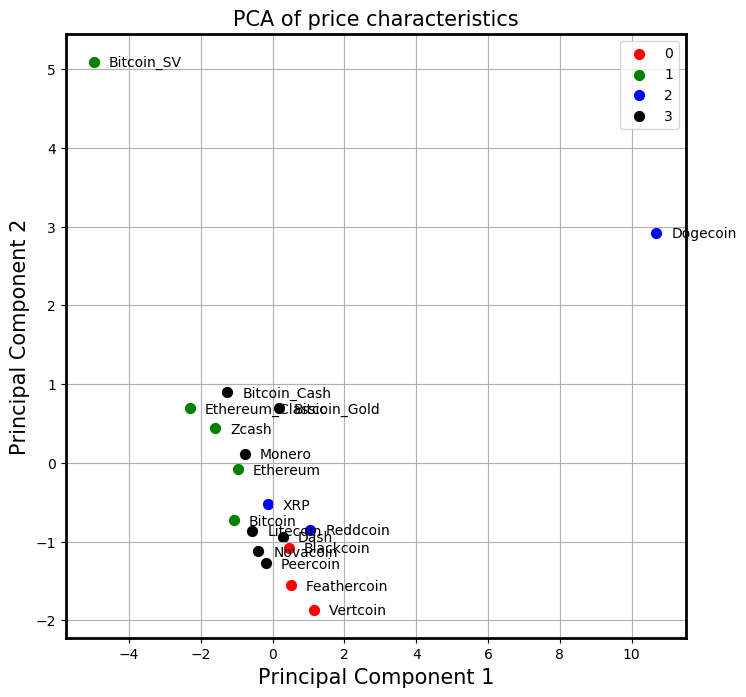

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA of '+ dataset+' characteristics', fontsize = 15)
targets = list(range(n_clusters))
colors = ['r', 'g', 'b','k', 'c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
for k, v in principalDf.iterrows():
    ax.annotate(k, v,xytext=(15,-5),textcoords='offset pixels', fontsize=10)

plt.savefig(dataset+'_charateristics_2d.png', transparent = True)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.index = df_PCA.index
finalDf = pd.concat([principalDf, df_PCA[['target']]], axis = 1)

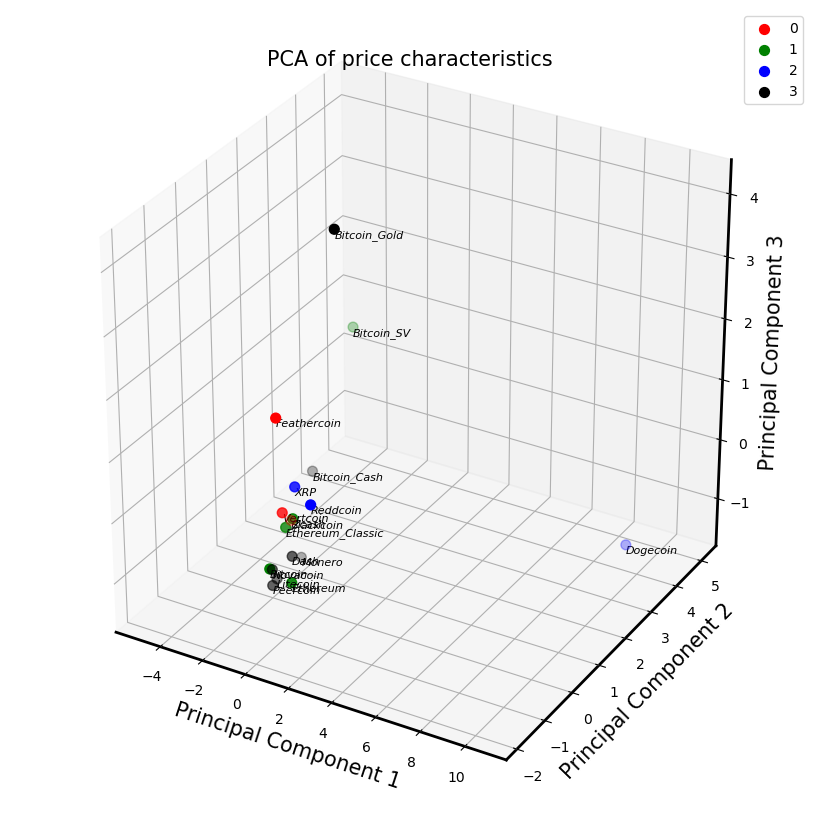

In [35]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8,8))
ax = ax = Axes3D(fig)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('PCA of '+ dataset+' characteristics', fontsize = 15)
targets = range(0, n_clusters)
colors = ['r', 'g', 'b','k','c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    x= finalDf.loc[indicesToKeep, 'principal component 1']
    y=  finalDf.loc[indicesToKeep, 'principal component 2']
    z= finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z
               , c = color
               , s = 50)
   # ax.text(x, y, z, '%s' % (label), size=20, zorder=1, color='k')
ax.legend(targets)
ax.grid()

x= finalDf.loc[:,'principal component 1']
y=  finalDf.loc[:,'principal component 2']
z= finalDf.loc[:,'principal component 3']
labels = finalDf.index
for x, y, z, label in zip(x, y, z, labels):
    ax.text(x, y, z, label, fontsize=8, horizontalalignment='left', verticalalignment='top',rotation=90, 
           style = 'italic', weight = 'ultralight')
plt.savefig(dataset+'_charateristics_3d.png', transparent = True)